# Online Analysis

Being able to visualize and interpret simulation data in real time is invaluable for understanding the behavior of a physical system.This example shows how to use SmartSim analyze the vorticity field during a simple, Python based Lattice Boltzmann fluid flow simulation.

In [1]:
from smartsim import Experiment
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("finite_volume_simulation", launcher="local")

Create the database

In [2]:
# create an Orchestrator database reference,
# generate it's output directory, and launch it locally
db = exp.create_database(port=6780, interface="lo")
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")

06:28:57 vm1 SmartSim[1376] INFO Working in previously created experiment
Database started at address: ['127.0.0.1:6780']


The file fv_sim.py contains python script for simulating the fluid flow past a cylinder using the Lattice Boltzmann method. If you are more intrested in implementation refer https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c

In [7]:
# set simulation parameters we can pass as executable arguments
time_steps, seed = 3000, 42

# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings("python3",
                                   exe_args=["fv_sim.py",
                                             f"--seed={seed}",
                                             f"--steps={time_steps}"])

# Create the Model reference to our simulation and
# attach needed files to be copied, configured, or symlinked into
# the Model directory at runtime.
model = exp.create_model("fv_simulation", settings)
model.attach_generator_files(to_copy="fv_sim.py")
exp.generate(model, overwrite=True)

06:35:08 vm1 SmartSim[1376] INFO Working in previously created experiment


In [8]:
# start simulation without blocking so data can be analyzed in real time
exp.start(model, block=False, summary=True)

06:35:26 vm1 SmartSim[1376] INFO 

=== Launch Summary ===
Experiment: finite_volume_simulation
Experiment Path: /home/azureuser/finite_volume_simulation
Launcher: local
Models: 1
Database Status: active

=== Models ===
fv_simulation
Executable: /usr/bin/python3
Executable Arguments: fv_sim.py --seed=42 --steps=3000





SmartRedis is used to pull the Datasets stored in the Orchestrator database by the simulation and use matplotlib to plot the results.

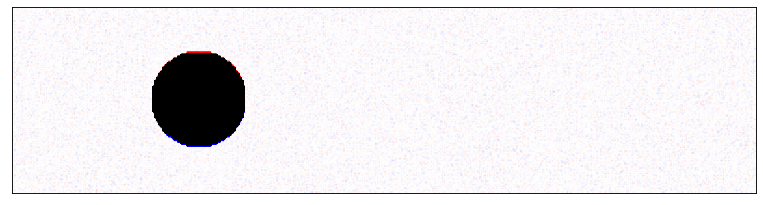

Vorticity plot at timestep: 0



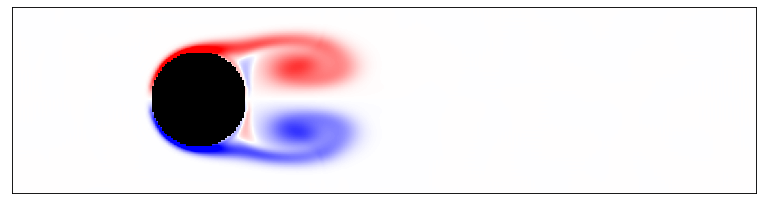

Vorticity plot at timestep: 700



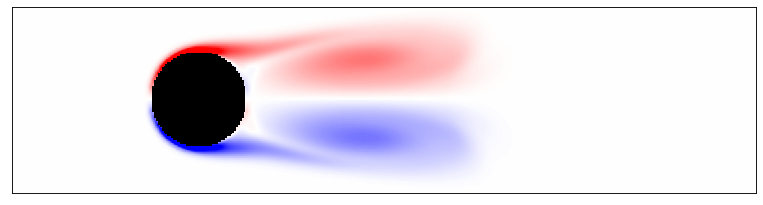

Vorticity plot at timestep: 1400



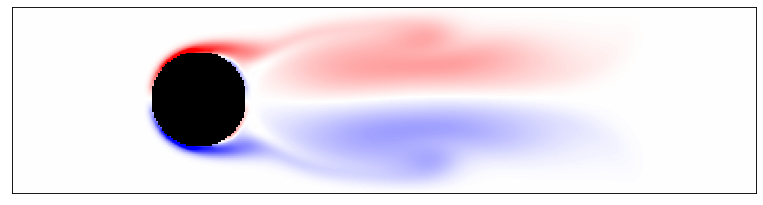

Vorticity plot at timestep: 2100



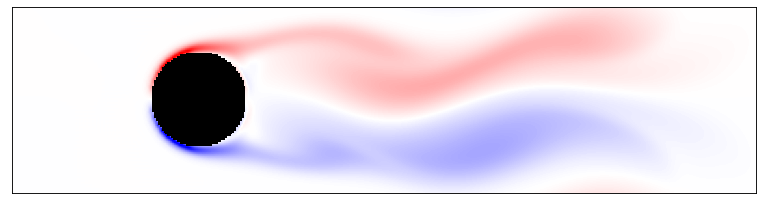

Vorticity plot at timestep: 2800



In [14]:
from smartredis import Client
from vishelpers1 import plot_lattice_vorticity
# connect a SmartRedis client to retrieve data while the
# simulation is producing it and storing it within the
# orchestrator database
client = Client(address=db.get_address()[0], cluster=False)

# Get the cylinder location in the mesh
client.poll_key(f"cylinder", 300, 1000)
cylinder = client.get_tensor("cylinder").astype(bool)

# plot every 700th timestep
for i in range(0, time_steps + 1, 700):
    client.poll_dataset(f"data_{i}", 300, 1000)
    dataset = client.get_dataset(f"data_{i}")
    ux, uy = dataset.get_tensor("ux"), dataset.get_tensor("uy")

    plot_lattice_vorticity(i, ux, uy, cylinder)

In [15]:
# Optionally clear the database
client.flush_db(db.get_address())

In [16]:
import time
# Use the Experiment API to wait until the model
# is finished and then terminate the database and
# release it's resources
while not exp.finished(model):
    time.sleep(5)

exp.stop(db)

06:41:57 vm1 SmartSim[1376] INFO Stopping model orchestrator_0 with job name orchestrator_0-CNEMM8PGWSUY


In [17]:
exp.get_status(model)

['Completed']

In [18]:
exp.summary(format="html")

,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fv_simulation,Model,1546,0,56.3238,Completed,0
1,orchestrator_0,DBNode,1403,0,780.643,Cancelled,-9
